# Import Require Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding , LSTM , Dense , Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df=pd.read_csv("C:/Users/mpc27/Downloads/AI_Human.csv/AI_Human.csv")
df

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


# Data Exploration

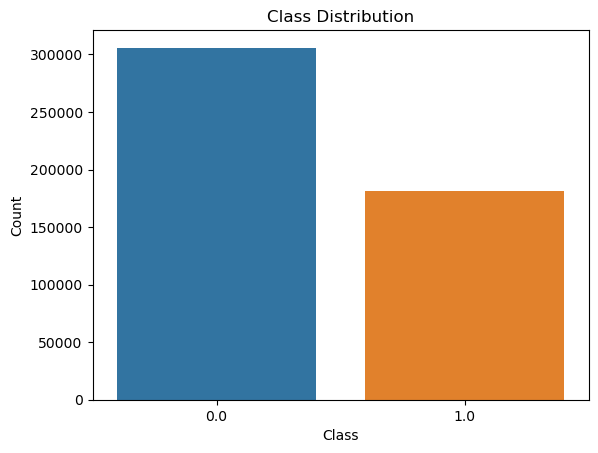

In [3]:
sns.countplot(x=df['generated'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

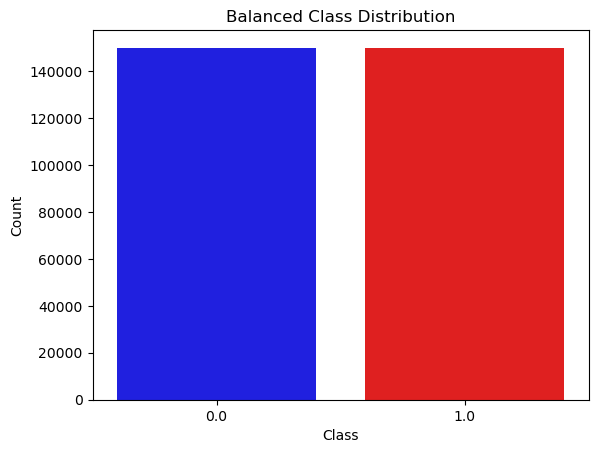

In [4]:
def balance_and_visualize(df):    
    # Check the class distribution
    class_counts = df['generated'].value_counts()

    # Determine the minimum class size (to balance the classes)
    min_class_size = class_counts.min()

    # Sample the minority class to balance it with the majority class
    class_0 = df[df['generated'] == 0].sample(min(min_class_size, 150000), random_state=42)
    class_1 = df[df['generated'] == 1].sample(min(min_class_size, 150000), random_state=42)

    # Concatenate the two balanced classes
    balanced_df = pd.concat([class_0, class_1])

    # Shuffle the data
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Plot the balanced class distribution using Seaborn with different colors
    sns.countplot(x='generated', data=balanced_df, palette={0: 'blue', 1: 'red'})

    # Add labels and title
    plt.title('Balanced Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Show the plot
    plt.show()
    
    # Return the balanced dataframe
    return balanced_df

# Call the function and store the new data in df
df = balance_and_visualize(df)

# Data Preprocessing

In [6]:
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [7]:
# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Define stopwords and lemmatizer
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def transform_text(text):
    text = text.lower()
    
    # Remove digits
    text = re.sub(r'\d', ' ', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    filter_tokenize = []
    
    # Replace specific tokens
    for token in tokens:
        token = token.replace("n't", "not")
        token = token.replace("$", "dollar")
        filter_tokenize.append(token)

    # Remove non-alphanumeric characters and stopwords
    tokens = []
    for token in filter_tokenize:
        if token.isalnum() and token not in english_stopwords:
            tokens.append(token)

    # Lemmatization
    filter_tokenize = []
    for token in tokens:
        filter_tokenize.append(lemmatizer.lemmatize(token))

    return ' '.join(filter_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mpc27\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mpc27\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df['transform_text']=df['text'].apply(transform_text)

In [9]:
df['transform_text']

0         article change exploring venus author suggests...
1         driverless car f becoming advanced invention w...
2         challenge exploring venus author suggests stud...
3         cell phone became ubiquitous modern society us...
4         dear principal writing uo express mh opinion p...
                                ...                        
299995    seagoing cowboy imagine boat way help people a...
299996    dear senator writing express ny view electoral...
299997    article patent venus sometimes called evening ...
299998    may concern opinion think keep electoral colle...
299999    many bad reason go seagoing one reason get kil...
Name: transform_text, Length: 300000, dtype: object

In [12]:
new_df = df.copy()

# Tokenization and Padding
max_words = 10000  # Maximum number of words to consider
max_len = 100      # Maximum length of sequences

# Tokenizer setup
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_df['transform_text'])
sequences = tokenizer.texts_to_sequences(new_df['transform_text'])
X_new = pad_sequences(sequences, maxlen=max_len)

# Label encoding
label_encoder = LabelEncoder()
y_new = label_encoder.fit_transform(new_df['generated'])

# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Train the Model

In [13]:
embedding_dim = 64  # Dimension of the embedding vector
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(X_train_new, y_train_new, epochs=5, batch_size=64, validation_data=(X_test_new, y_test_new))

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 408s 109ms/step - accuracy: 0.9997 - loss: 7.6360e-04 - val_accuracy: 0.9977 - val_loss: 0.0131
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 405s 108ms/step - accuracy: 0.9997 - loss: 9.1424e-04 - val_accuracy: 0.9977 - val_loss: 0.0106
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 411s 110ms/step - accuracy: 0.9997 - loss: 8.7998e-04 - val_accuracy: 0.9980 - val_loss: 0.0098
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 405s 108ms/step - accuracy: 0.9999 - loss: 4.8861e-04 - val_accuracy: 0.9977 - val_loss: 0.0115
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 407s 108ms/step - accuracy: 0.9998 - loss: 6.1109e-04 - val_accuracy: 0.9978 - val_loss: 0.0126


# Test the Model

In [75]:
z="maaay name is sahil"
z=[z]

In [76]:
tokenizer.fit_on_texts(z)
sequences = tokenizer.texts_to_sequences(z)
output= pad_sequences(sequences, maxlen=max_len)

In [77]:
model.predict(output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([[1.]], dtype=float32)

# Performance Metrics

Training Accuracy: 0.9998
Validation Accuracy: 0.9978
Training Loss: 0.0008
Validation Loss: 0.0126




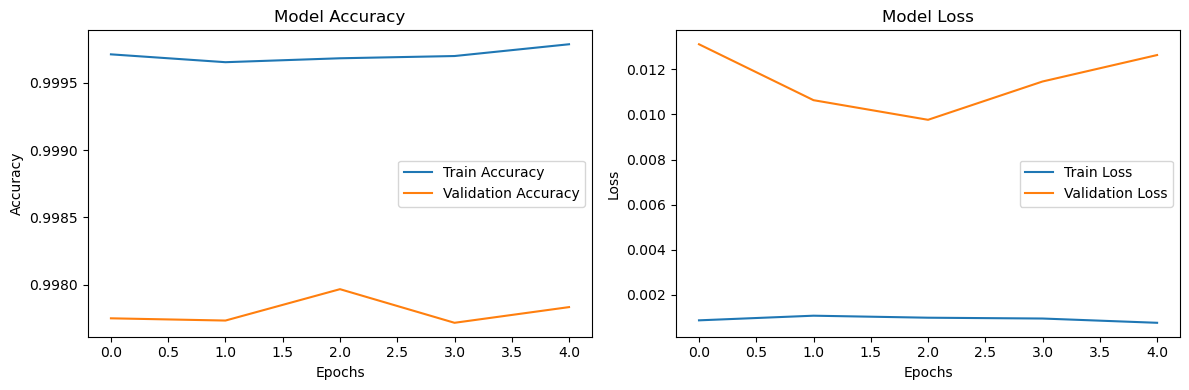

In [74]:

# Function to plot training history
def plot_history(history):
    # Print final train and validation accuracies and losses
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print("\n========================================\n")

    plt.figure(figsize=(12, 4))
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_history(history)

In [29]:
model.save('LSTM_Model.h5')  # Saves the model to an H5 file

In [36]:
import pickle
pickle.dump(tokenizer,open('Tokenizer.pkl','wb'))